In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from scipy.signal import stft, istft, get_window
from scipy.fftpack import fft, fftshift, fftfreq
from IPython.display import Audio
from tqdm import tnrange, tqdm_notebook, tqdm
from dlbeamformer_utilities import *
from dlbeamformers import *
from utilities import *
from IPython.display import Audio

random_seed = 0
# Make pretty figures
palette, cmap = config_figures()

VISUALIZE_BEAMPATTERNS = True

In [2]:
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data, test_data = load_data(datapath)

sampling_frequency, stft_params, sound_speed = parse_parameters()

signal_max_frequency = sampling_frequency / 2

# Array geometry
pos_x = np.array([-35.0, -35.0, 0.0, 35.0, 35.0, 0.0, 0.0]) * 1e-3
pos_y = np.array([20.0, -20.0, -40.0, -20.0, 20.0, 40.0, 0.0]) * 1e-3
n_mics = len(pos_x)
pos_z = np.zeros(n_mics)
array_geometry = np.row_stack((pos_x, pos_y, pos_z))

# Fix elevation angle
elevation = -90 # [degree]

# Source/Target/Look angles
elevation_s = np.array([elevation]) # [degree]
azimuth_s = np.array([180])
source_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=elevation_s, 
        azimuth_grid=azimuth_s)

# Scanning angles
scanning_elevation_grid = np.array([elevation]) # [degree]
scanning_azimuth_grid = np.arange(0, 360, 0.1) # [degree]
scanning_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=scanning_elevation_grid, 
        azimuth_grid=scanning_azimuth_grid)

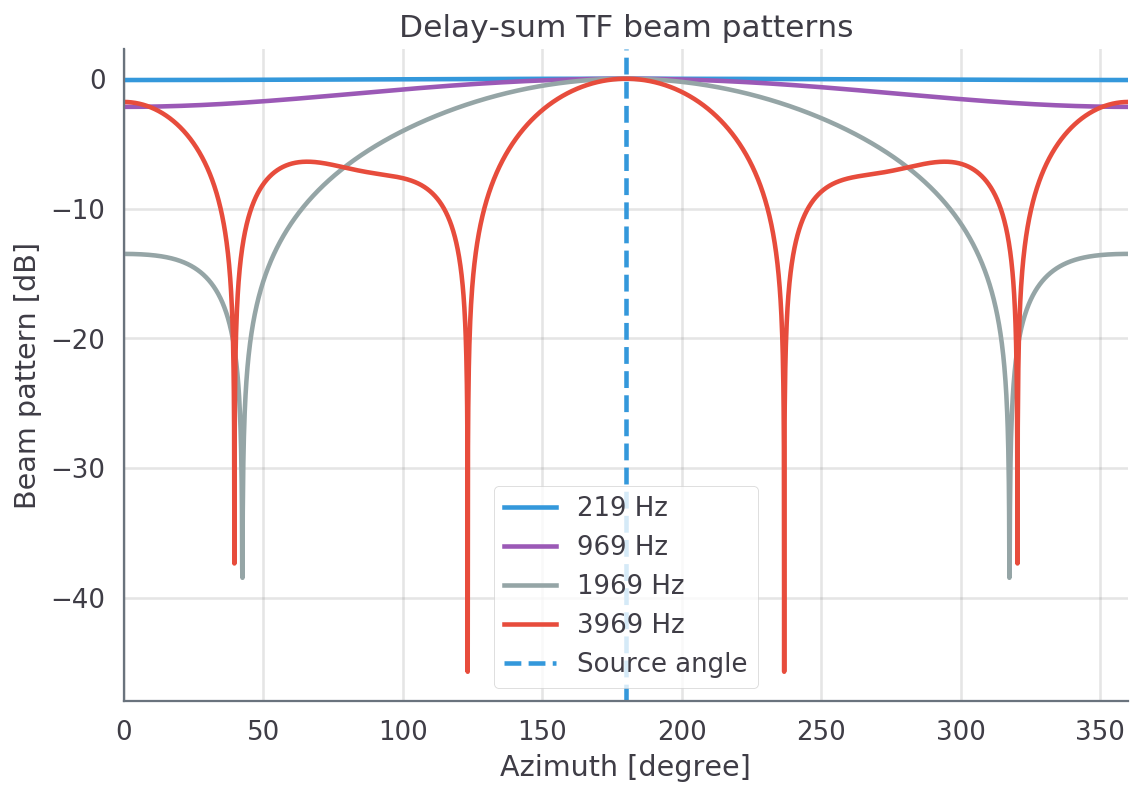

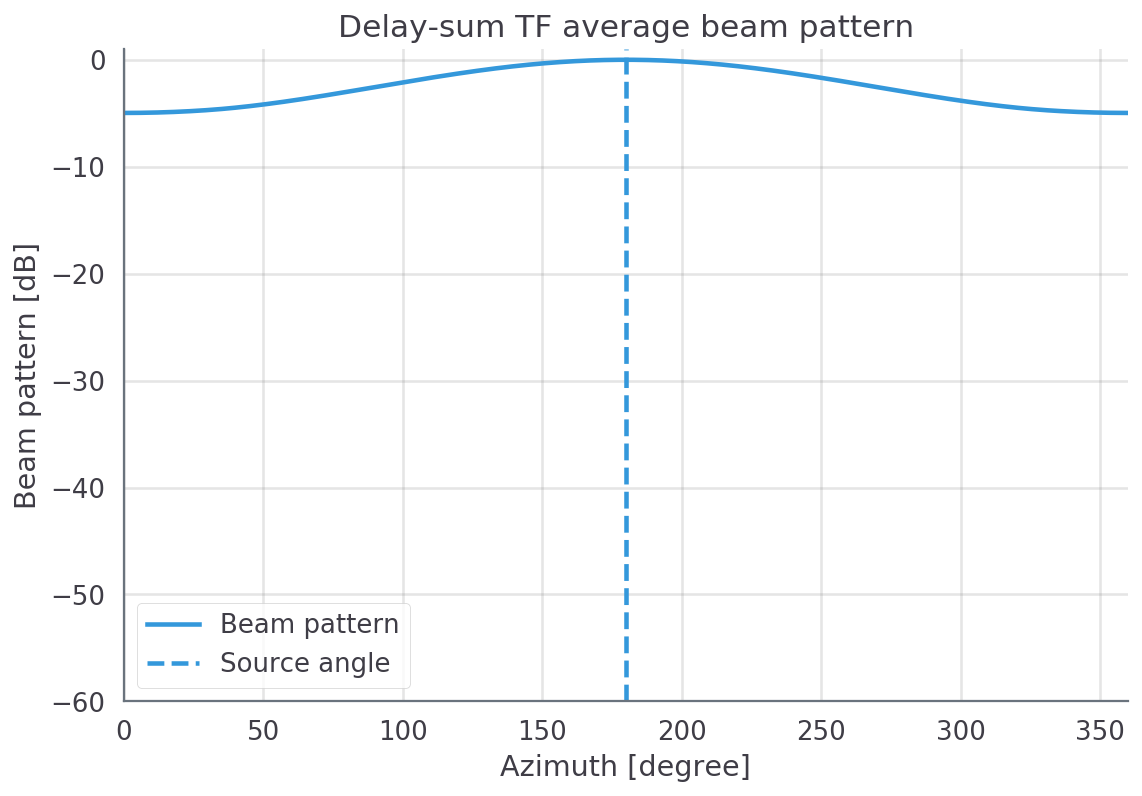

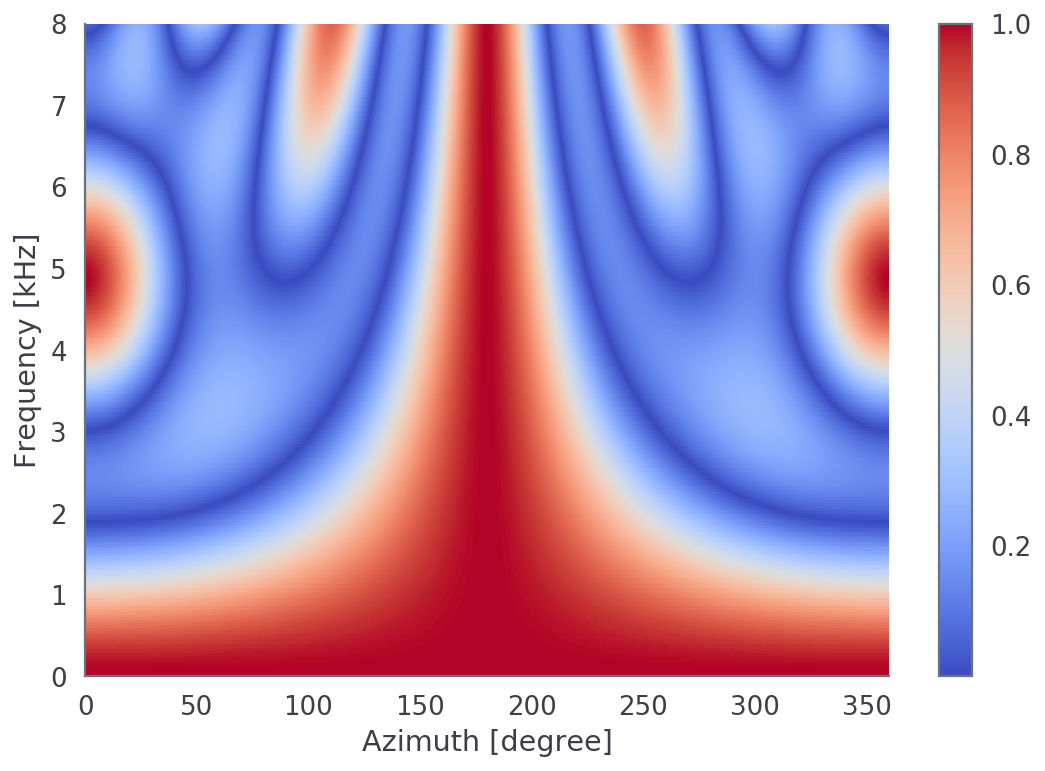

In [3]:
ds_tf_beamformers = 1./n_mics * source_steering_vectors

# Delay-sum beam pattern
ds_tf_beampattern = compute_tf_beampattern(ds_tf_beamformers[:, 0, 0, :], scanning_steering_vectors)
ds_tf_beampattern_db = to_db(ds_tf_beampattern)

if VISUALIZE_BEAMPATTERNS:
    frequency_bins = [7, 31, 63, 127]
    visualize_beampattern_1d(ds_tf_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
        signal_max_frequency, source_azimuths= azimuth_s, title="Delay-sum TF beam patterns")

    visualize_beampattern_1d_average(np.abs(ds_tf_beampattern[:, 0, :]), scanning_azimuth_grid, 
        frequency_range=(0, 63), source_azimuths=azimuth_s, title="Delay-sum TF average beam pattern")

    visualize_beampattern_2d(np.abs(ds_tf_beampattern[:, 0, :]), 
        scanning_azimuth_grid, signal_max_frequency);

In [4]:
np.random.seed(random_seed)
n_interferences = 1
azimuth_step = 5
n_samples_each_config = len(train_data)
training_azimuths = list(np.arange(0, 360, azimuth_step))
training_elevations = np.array([-90])
training_angles = {
    "elevation": training_elevations,
    "azimuth": training_azimuths
}
noisy = False
training_tf_filename = \
    "circular_CMU_ARCTIC_tf_training_covariance_data_azimuth_step_{}_config_trainning_samples_{}_n_interferences_{}.pkl".format(
        azimuth_step, n_samples_each_config, n_interferences
    )
if noisy == True:
    training_tf_filename = "noisy_" + training_tf_filename
training_tf_path = "/data/dung/dlbeamformer/tf_training_data"
training_tf_filepath = os.path.join(training_tf_path, training_tf_filename)

training_interference_covariance = prepare_multichannel_covariance_data(
                    array_geometry, train_data, n_interferences, training_angles,
                    azimuth_step, n_samples_each_config, sampling_frequency,
                    stft_params, training_tf_filepath, random_seed=0, SAVE=False)

source_angles = [
    {
        "elevation": elevation_s,
        "azimuth": azimuth_s
    }
]
angle_grid = {
    "elevation": scanning_elevation_grid,
    "azimuth": scanning_azimuth_grid
}
dlbeamformer = DictionaryLearningBeamformer(array_geometry, sampling_frequency,
        source_angles, stft_params, angle_grid, diagonal_loading_param=5, bf_type="NC")
desired_null_width = 5 # [degree]
null_constraint_threshold = 0.001
n_atoms_each_config = 1
batch_size = 100
dlbeamformer.fit(training_interference_covariance, desired_null_width, 
                null_constraint_threshold, eigenvalue_percentage_threshold=0.99,
                batch_size=batch_size, n_atoms_each_config=n_atoms_each_config)
dlbeamformer_filename = \
    "circular_CMU_ARCTIC_dlbeamformer_azimuth_step_{}_config_atoms_{}_n_interferences_{}_batch_size_{}.pkl".format(
        azimuth_step, n_atoms_each_config, n_interferences, batch_size)
trained_models_path = "/data/dung/dlbeamformer/trained_models"
dlbeamformer_filepath = os.path.join(trained_models_path, dlbeamformer_filename)

Training configuration: 100%|██████████| 72/72 [00:08<00:00, 13.10it/s]


In [5]:
import importlib
import dlbeamformers
importlib.reload(dlbeamformers)
from dlbeamformers import *
batch_size = 100
dl = DLBeamformer(array_geometry, sampling_frequency,
        source_angles, stft_params, angle_grid, diagonal_loading_param=5,
        n_dict_atoms=len(training_azimuths), n_nonzero_coefficients=10, 
        n_train_max_iterations=20, train_error_tolerance=1e-5)
dl.fit(training_interference_covariance, desired_null_width, 
                null_constraint_threshold, eigenvalue_percentage_threshold=0.99,
                batch_size=batch_size, n_train_batches_each_config=3)

Initialize DLBeamformer


Training iteration:   5%|▌         | 1/20 [01:07<21:20, 67.37s/it]

		Train loss at current iteration 224762313629999.437500000


Training iteration:  10%|█         | 2/20 [02:11<19:55, 66.39s/it]

		Train loss at current iteration 0.000218660


Training iteration:  15%|█▌        | 3/20 [03:14<18:31, 65.39s/it]

		Train loss at current iteration 0.000412981


Training iteration:  20%|██        | 4/20 [04:08<16:31, 61.96s/it]

		Train loss at current iteration 0.000483055


Training iteration:  25%|██▌       | 5/20 [05:02<14:53, 59.59s/it]

		Train loss at current iteration 0.000500130


Training iteration:  30%|███       | 6/20 [05:56<13:30, 57.90s/it]

		Train loss at current iteration 0.000437648


Training iteration:  35%|███▌      | 7/20 [06:50<12:17, 56.70s/it]

		Train loss at current iteration 0.000213022


Training iteration:  40%|████      | 8/20 [07:44<11:10, 55.86s/it]

		Train loss at current iteration 0.000505927


Training iteration:  45%|████▌     | 9/20 [08:38<10:08, 55.34s/it]

		Train loss at current iteration 0.000503474


Training iteration:  50%|█████     | 10/20 [09:32<09:09, 54.91s/it]

		Train loss at current iteration 0.000246931


Training iteration:  55%|█████▌    | 11/20 [10:27<08:13, 54.89s/it]

		Train loss at current iteration 0.000240078


Training iteration:  60%|██████    | 12/20 [11:21<07:17, 54.64s/it]

		Train loss at current iteration 0.000289840


Training iteration:  65%|██████▌   | 13/20 [12:15<06:21, 54.48s/it]

		Train loss at current iteration 0.000604036


Training iteration:  70%|███████   | 14/20 [13:09<05:26, 54.37s/it]

		Train loss at current iteration 0.000186010


Training iteration:  75%|███████▌  | 15/20 [14:03<04:31, 54.28s/it]

		Train loss at current iteration 0.000537048


Training iteration:  80%|████████  | 16/20 [14:57<03:36, 54.19s/it]

		Train loss at current iteration 0.000213313


Training iteration:  85%|████████▌ | 17/20 [15:51<02:42, 54.18s/it]

		Train loss at current iteration 0.000194431


Training iteration:  90%|█████████ | 18/20 [16:45<01:48, 54.15s/it]

		Train loss at current iteration 0.000334221


Training iteration:  95%|█████████▌| 19/20 [17:40<00:54, 54.19s/it]

		Train loss at current iteration 0.000233984


Training iteration: 100%|██████████| 20/20 [18:34<00:00, 54.22s/it]

		Train loss at current iteration 0.000447683


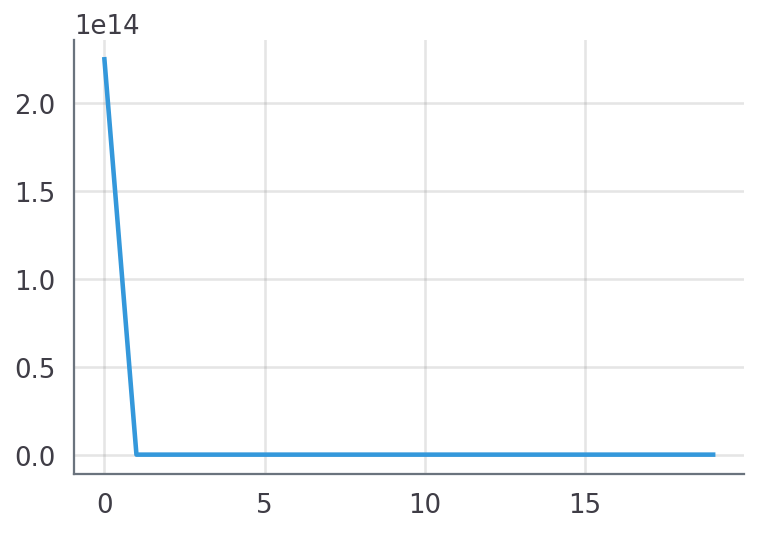

In [6]:
plt.plot(dl.training_loss)

In [15]:
print(dl.weights_[0].shape)
print(dl.weights_[1].shape)
dw = dl.weights_[2]
w = np.zeros((256, 7, 1), dtype=np.complex64)
# w2 = np.zeros((256, 7, 1), dtype=np.complex64)
for i in range(256):
    w[i] = dl.weights_[0][0][i].dot(dl.weights_[1][0, i, :, 15]).reshape(7, 1)
#     w2[i] = dl.weights_[0][0][i].dot(dl.weights_[1][0, i, :, 1]).reshape(7, 1)

(1, 256, 7, 72)
(1, 256, 72, 216)


In [8]:
np.random.seed(random_seed)
n_interferences = 1
input_sinrs_db = np.arange(-15, 16, 2)
input_inr_db = 0
input_inr = from_db(input_inr_db)
beamformer_list = ["DS", "MVDR", "MPDR", "DL-MVDR", "DL-MPDR"]
beamformer_list = ["mvdr"]
beamformers = {}
for beamformer_name in beamformer_list:
    beamformers[beamformer_name] = {
        "weights": [None]*len(input_sinrs_db),
        "sinr_db": [None]*len(input_sinrs_db),
        "average_sinr_db": [],
        "out": [None]*len(input_sinrs_db),
        "ir_db": [None] * len(input_sinrs_db),
        "average_ir_db": [],
        "nr_db": [None] * len(input_sinrs_db),
        "average_nr_db": [],
        "sr_db": [None] * len(input_sinrs_db),
        "average_sr_db": []
    }
        
n_MC_iters = 1
for i_input_sinr in tqdm(range(len(input_sinrs_db)), desc="Input SINR"):
    input_sinr = from_db(input_sinrs_db[i_input_sinr])
    for beamformer_name in beamformer_list:
        beamformers[beamformer_name]["weights"][i_input_sinr] = []
        beamformers[beamformer_name]["sinr_db"][i_input_sinr] = []
        beamformers[beamformer_name]["out"][i_input_sinr] = []
        beamformers[beamformer_name]["ir_db"][i_input_sinr] = []
        beamformers[beamformer_name]["nr_db"][i_input_sinr] = []
        beamformers[beamformer_name]["sr_db"][i_input_sinr] = []
    for i_MC_iter in tqdm(range(n_MC_iters), desc="Monte Carlo iterations"):
    
        source = {
            "signal": test_data[np.random.choice(len(test_data))],
            "elevation": elevation_s,
            "azimuth": azimuth_s
        }
        
        interferences = []
        interference_signals = []
        for i_interference in range(n_interferences):
            random_azimuth_1 = np.random.uniform(scanning_azimuth_grid[0], azimuth_s - 30)[0]
            random_azimuth_2 = np.random.uniform(azimuth_s + 30, scanning_azimuth_grid[-1])[0]
            random_azimuth = np.random.choice(np.array([random_azimuth_1, random_azimuth_2]))
            interference_signal = test_data[np.random.choice(len(test_data))]
            interference = {
                "signal": interference_signal,
                "elevation": np.array([elevation]),
                "azimuth": np.array([np.random.uniform(
                    scanning_azimuth_grid[0], scanning_azimuth_grid[-1])])
#                 "azimuth": np.array([30])
#                 "azimuth": np.array([random_azimuth])
            }
            interferences.append(interference)
        
        received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel \
            = simulate_multichannel_tf_mixtures(array_geometry, source,
                interferences, sampling_frequency, stft_params, input_inr, input_sinr)
        
        for beamformer_name in beamformer_list:        
            if beamformer_name.lower() == "ds":
                tf_frames_multichannel = None
            elif beamformer_name.lower() in ["mvdr", "dl-mvdr"]:
                tf_frames_multichannel = interference_stft_multichannel
            elif beamformer_name.lower() in ["mpdr", "dl-mpdr"]:
                tf_frames_multichannel = received_stft_multichannel

            if beamformer_name.lower() in ["dl-mvdr", "dl-mpdr"]:
                source_angle_index = 0
                tf_beamformer = dlbeamformer.choose_weights(source_angle_index,
                                    tf_frames_multichannel)
            else:
                tf_beamformer = compute_tf_beamformers(source_steering_vectors[:, 0, 0, :], 
                        beamformer_name=beamformer_name,
                        tf_frames_multichannel=tf_frames_multichannel,
                        diagonal_loading_param=5)

            # Compute beamformer output and SINR
            tf_out, out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                received_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            sinr_db, sinr  = compute_sinr(source_stft_multichannel, 
                interference_stft_multichannel+noise_stft_multichannel, tf_beamformer)

            # Compute interference output and interference reduction
            interference_tf_out, interference_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                interference_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            interference_reduction = compute_power(interference_stft_multichannel[:, 0, :]) / compute_power(interference_tf_out)
            interference_reduction_db = to_db(interference_reduction)
            
            # Compute noise output and noise reduction
            noise_tf_out, noise_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                noise_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            noise_reduction = compute_power(noise_stft_multichannel[:, 0, :]) / compute_power(noise_tf_out)
            noise_reduction_db = to_db(noise_reduction)
            
            # Compute source output and source distortion/reduction
            source_tf_out, source_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                source_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            source_reduction = compute_power(source_stft_multichannel[:, 0, :]) / compute_power(source_tf_out)
            source_reduction_db = to_db(source_reduction)
            
            beamformers[beamformer_name]["weights"][i_input_sinr].append(tf_beamformer)
            beamformers[beamformer_name]["sinr_db"][i_input_sinr].append(sinr_db[0][0])
            beamformers[beamformer_name]["out"][i_input_sinr].append(out)
            beamformers[beamformer_name]["ir_db"][i_input_sinr].append(interference_reduction_db)
            beamformers[beamformer_name]["nr_db"][i_input_sinr].append(noise_reduction_db)
            beamformers[beamformer_name]["sr_db"][i_input_sinr].append(source_reduction_db)

    for beamformer_name in beamformers.keys():
        beamformers[beamformer_name]["average_sinr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["sinr_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_ir_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["ir_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_nr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["nr_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_sr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["sr_db"][i_input_sinr])))))

Input SINR: 100%|██████████| 16/16 [00:02<00:00,  5.71it/s]


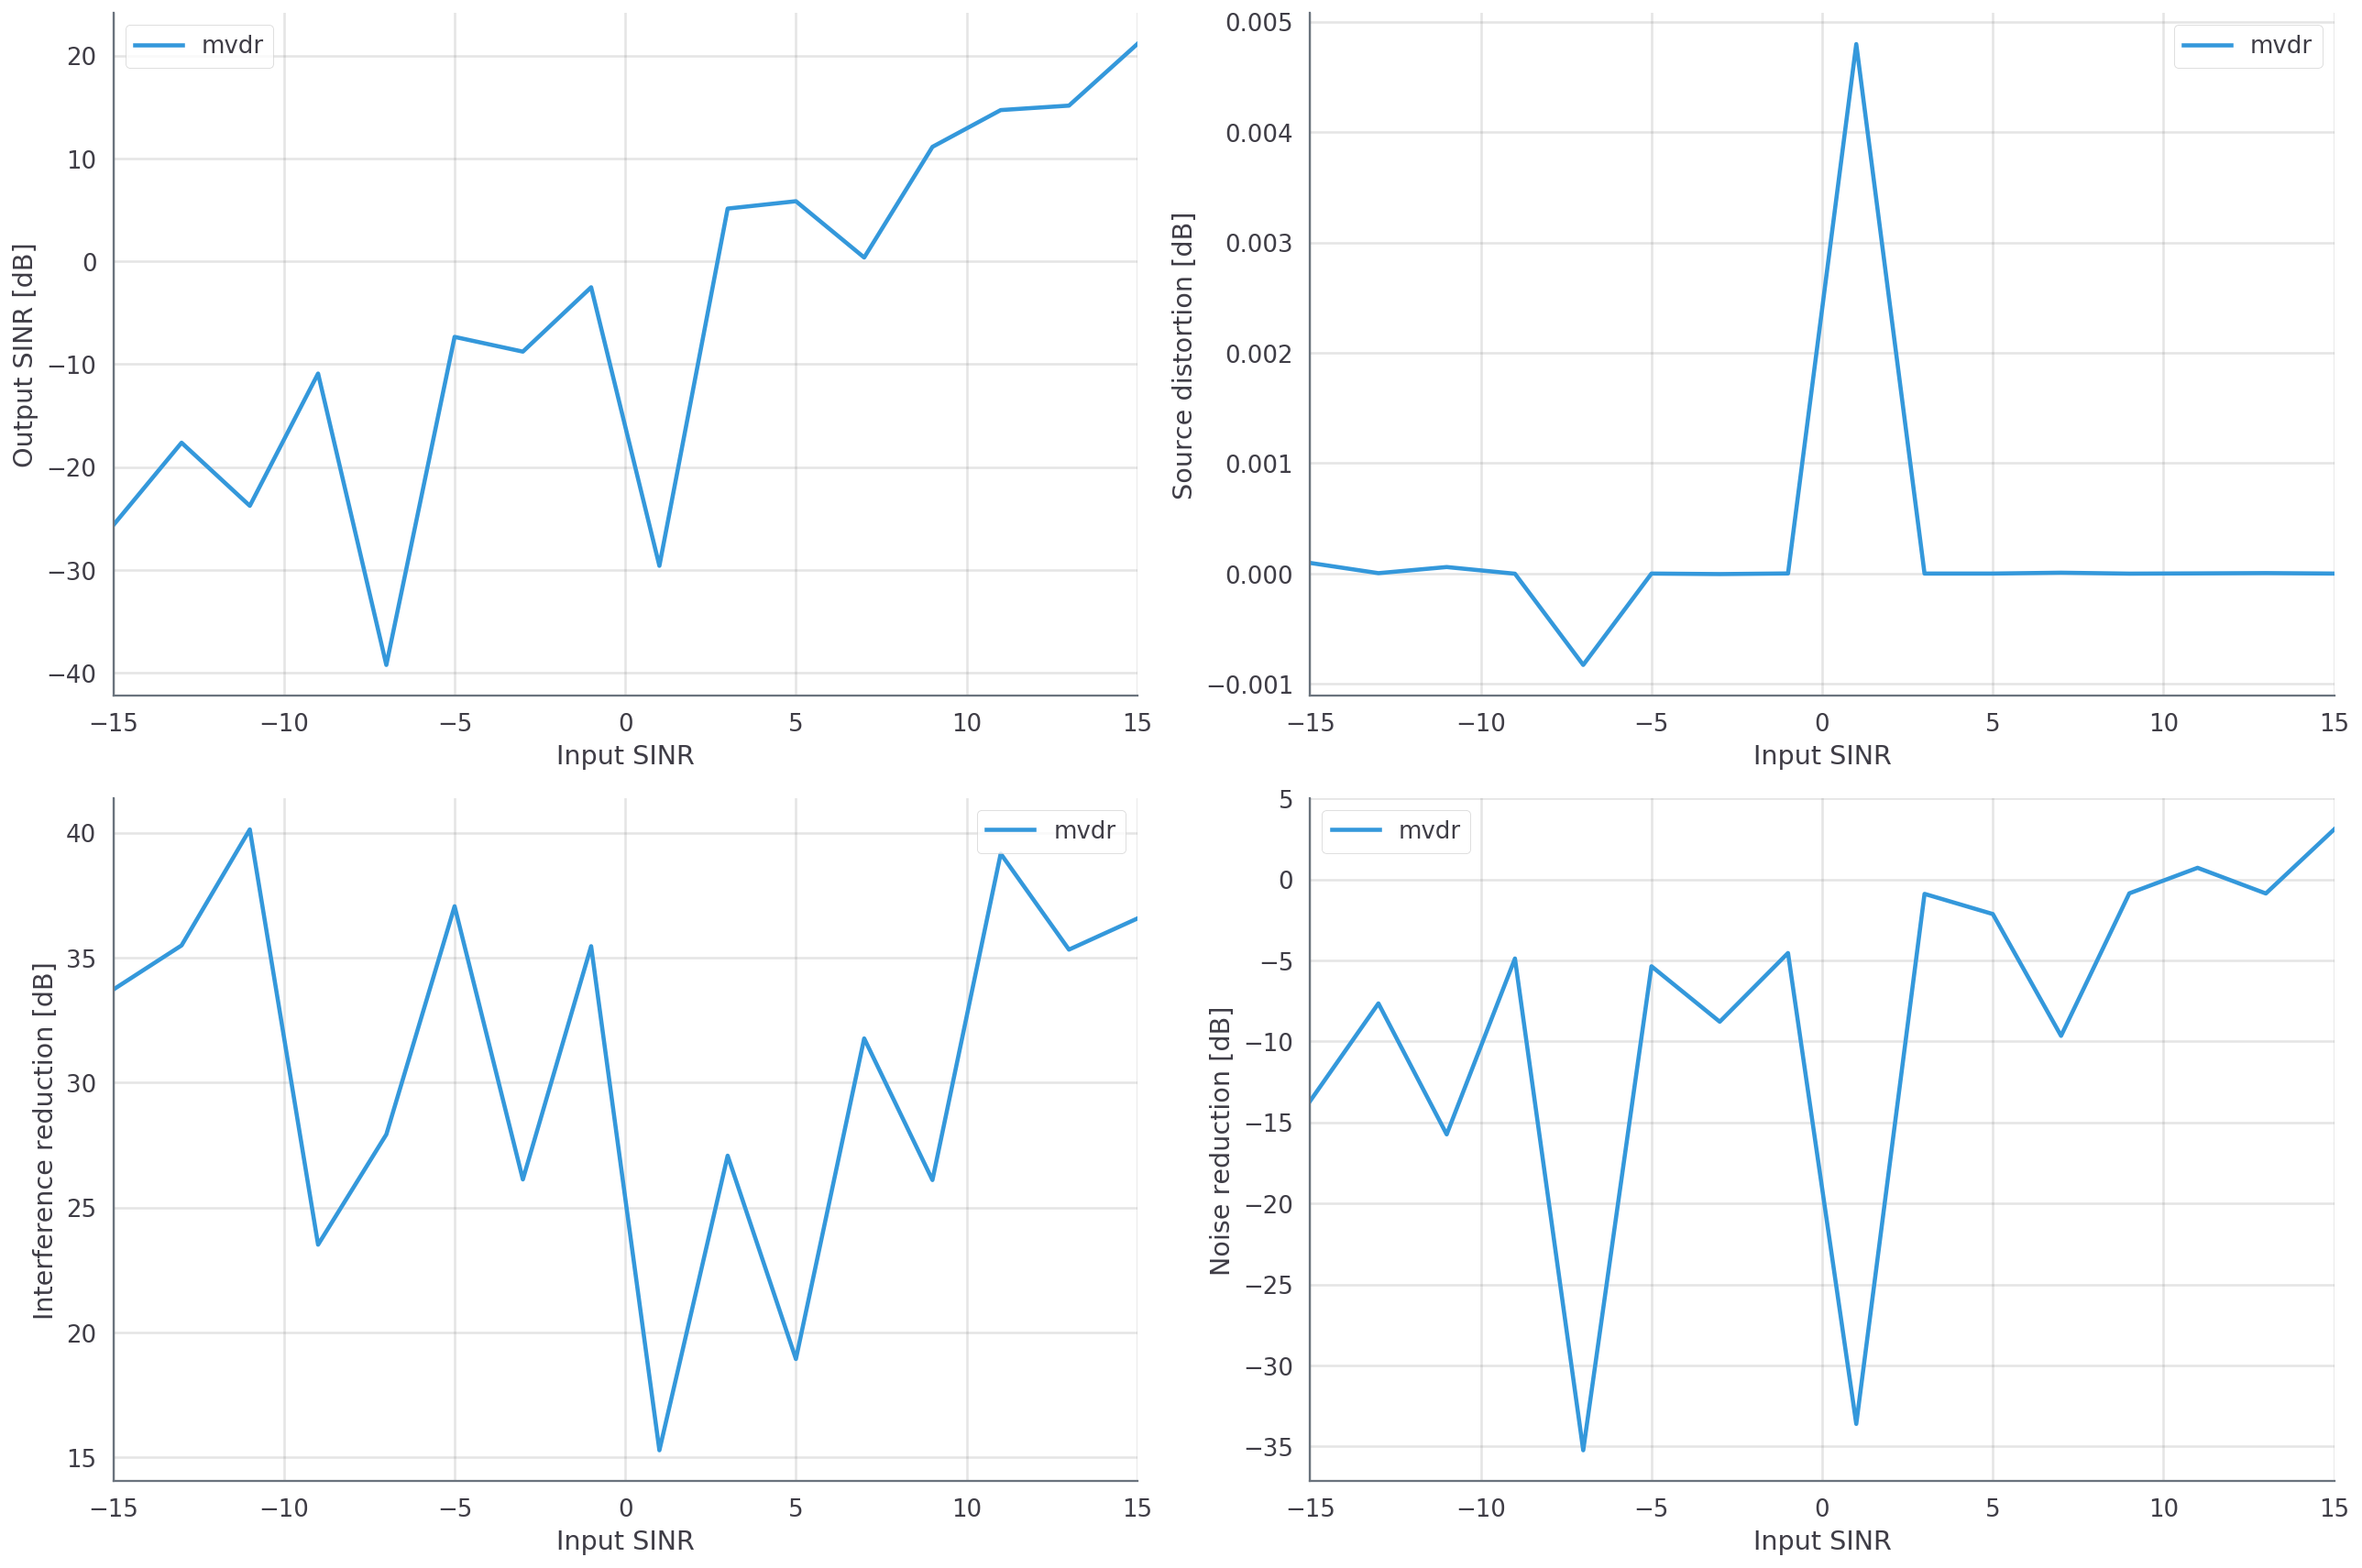

In [9]:
fig = plt.figure(figsize=(18, 12)); 
ax = fig.add_subplot(221);
for beamformer_name in beamformer_list:
    ax.plot(input_sinrs_db, beamformers[beamformer_name]["average_sinr_db"], label=beamformer_name)
ax.set_xlim(input_sinrs_db[0], input_sinrs_db[-1]);
ax.set_xlabel("Input SINR"); ax.set_ylabel("Output SINR [dB]");
plt.legend();

ax = fig.add_subplot(222);
for beamformer_name in beamformer_list:
    ax.plot(input_sinrs_db, beamformers[beamformer_name]["average_sr_db"], label=beamformer_name)
ax.set_xlim(input_sinrs_db[0], input_sinrs_db[-1]);
ax.set_xlabel("Input SINR"); ax.set_ylabel("Source distortion [dB]");
plt.legend();

ax = fig.add_subplot(223);
for beamformer_name in beamformer_list:
    ax.plot(input_sinrs_db, beamformers[beamformer_name]["average_ir_db"], label=beamformer_name)
ax.set_xlim(input_sinrs_db[0], input_sinrs_db[-1]);
ax.set_xlabel("Input SINR"); ax.set_ylabel("Interference reduction [dB]");
plt.legend();

ax = fig.add_subplot(224);
for beamformer_name in beamformer_list:
    ax.plot(input_sinrs_db, beamformers[beamformer_name]["average_nr_db"], label=beamformer_name)
ax.set_xlim(input_sinrs_db[0], input_sinrs_db[-1]);
ax.set_xlabel("Input SINR"); ax.set_ylabel("Noise reduction [dB]");
plt.legend();
plt.tight_layout()
fig_name = "figures/benchmark_dl_inputINR_{}dB.jpg".format(input_inr_db)
plt.savefig(fig_name, dpi=600)

In [10]:
fig_name = "benchmark_dl_inputINR_{}db.jpg".format(input_inr_db)

In [11]:
play_tf_frames(interference_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
# Audio(interference["signal"], rate=sampling_frequency, autoplay=True)

In [12]:
stft_window = stft_params["window"]
n_samples_per_frame = stft_params["n_samples_per_frame"]
hop_size = stft_params["hop_size"]
t, ss = istft(source_stft_multichannel[:, 0, :], fs=sampling_frequency, 
    window=stft_window, nperseg=n_samples_per_frame, 
    noverlap=n_samples_per_frame-hop_size,
    nfft=n_samples_per_frame, boundary=True)
Audio(ss, rate=sampling_frequency, autoplay=True)
# plt.plot(ss)

In [13]:
# frequency_bins = [7, 31, 63, 127]
# dl_beampattern = compute_tf_beampattern(beamformers["dlbeamformer"]["weights"], scanning_steering_vectors)
# dl_beampattern_db = to_db(dl_beampattern)

# visualize_beampattern_1d(dl_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
#     signal_max_frequency, source_azimuths= azimuth_s, title="DL TF beam patterns")

# visualize_beampattern_1d_average(np.abs(dl_beampattern[:, 0, :]), scanning_azimuth_grid, 
#     frequency_range=(0, 127), source_azimuths=azimuth_s, title="DL TF average beam pattern")

# visualize_beampattern_2d(np.abs(dl_beampattern[:, 0, :]), 
#     scanning_azimuth_grid, signal_max_frequency);

# def visualize_beampatterns(beamformer, scanning_steering_vector, scanning_azimuth_grid, 
#         source_azimuths, signal_max_frequency, frequency_bins, frequency_range, title=None):
#     beampattern = compute_tf_beampattern(beamformer, scanning_steering_vectors)
#     beampattern_db = to_db(beampattern)
    
#     visualize_beampattern_1d(dl_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
#         signal_max_frequency, source_azimuths= azimuth_s, title="DL TF beam patterns")

#     visualize_beampattern_1d_average(np.abs(dl_beampattern[:, 0, :]), scanning_azimuth_grid, 
#         frequency_range=(0, 127), source_azimuths=azimuth_s, title="DL TF average beam pattern")

#     visualize_beampattern_2d(np.abs(dl_beampattern[:, 0, :]), 
#         scanning_azimuth_grid, signal_max_frequency);
    


In [14]:
beamformer_list = ["delaysum", "mvdr", "mpdr", "dlbeamformer"]
beamformer_name = beamformer_list[2]
# len(beamformers[beamformer_name]["out"])
Audio(beamformers[beamformer_name]["out"][2][0], rate=sampling_frequency, autoplay=True)
# play_tf_frames(interference_stft_multichannel[:, 0, :]+noise_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
# play_tf_frames(received_stft_multichannel[:, 0, :], sampling_frequency, stft_params)

KeyError: 'mpdr'

In [ ]:
beamformers["mvdr"]["weights"][3][0].shape

In [ ]:
# MVDR beam pattern
mvdr_tf_beampattern = compute_tf_beampattern(beamformers["mvdr"]["weights"][3][0], scanning_steering_vectors)
mvdr_tf_beampattern_db = to_db(mvdr_tf_beampattern)

if VISUALIZE_BEAMPATTERNS:
    frequency_bins = [7, 31, 63, 127]
    visualize_beampattern_1d(mvdr_tf_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
        signal_max_frequency, source_azimuths= azimuth_s, title="MVDR TF beam patterns")

    visualize_beampattern_1d_average(np.abs(mvdr_tf_beampattern[:, 0, :]), scanning_azimuth_grid, 
        frequency_range=(0, 63), source_azimuths=azimuth_s, title="MVDR TF average beam pattern")

    visualize_beampattern_2d(np.abs(mvdr_tf_beampattern[:, 0, :]), 
        scanning_azimuth_grid, signal_max_frequency);

(256, 7, 1)


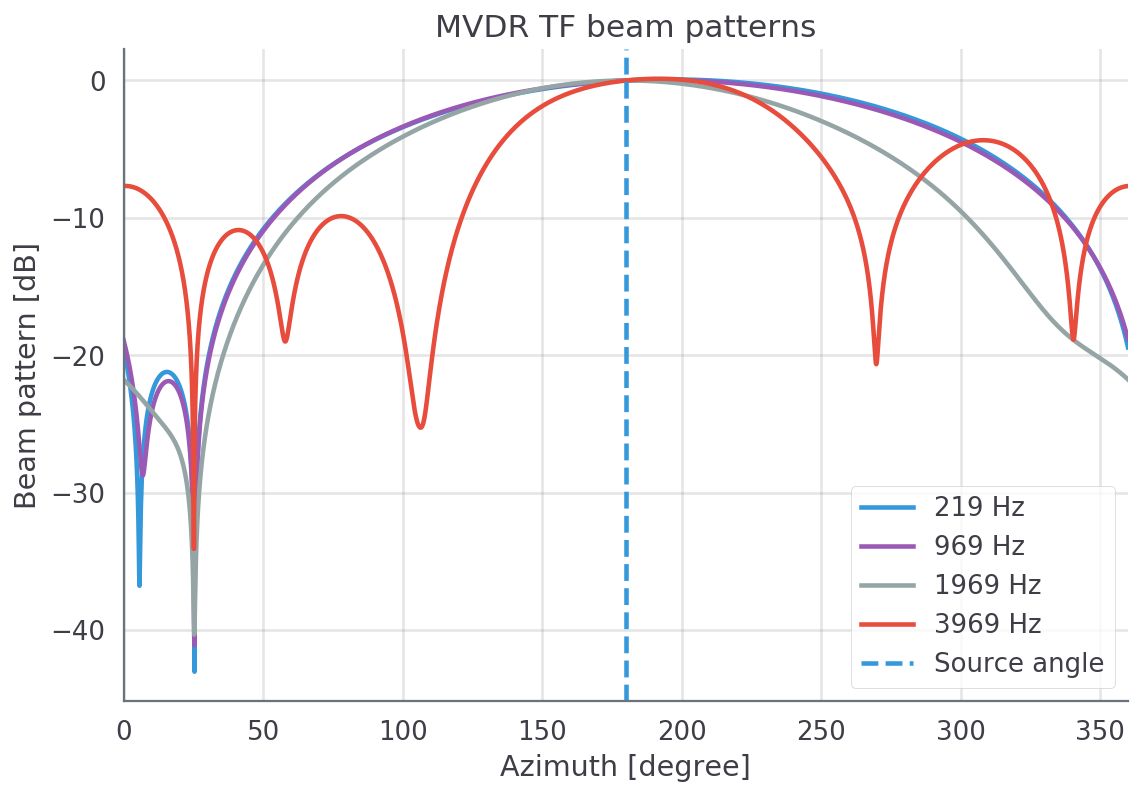

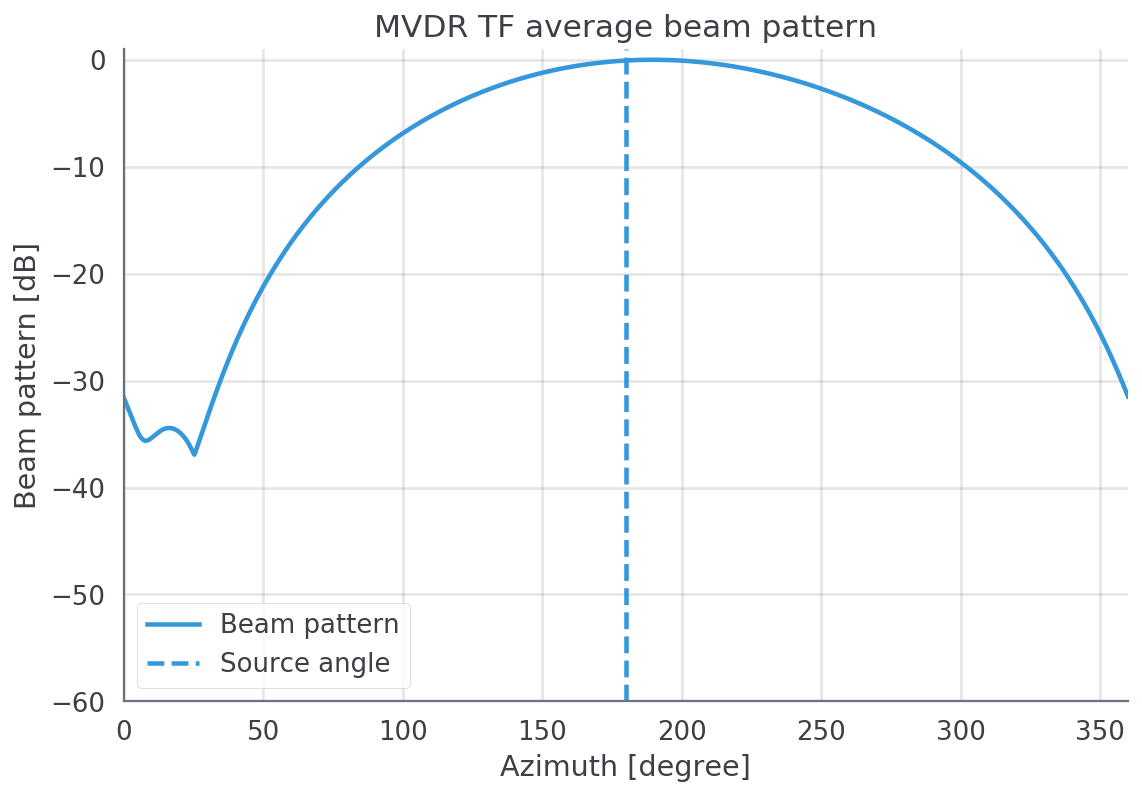

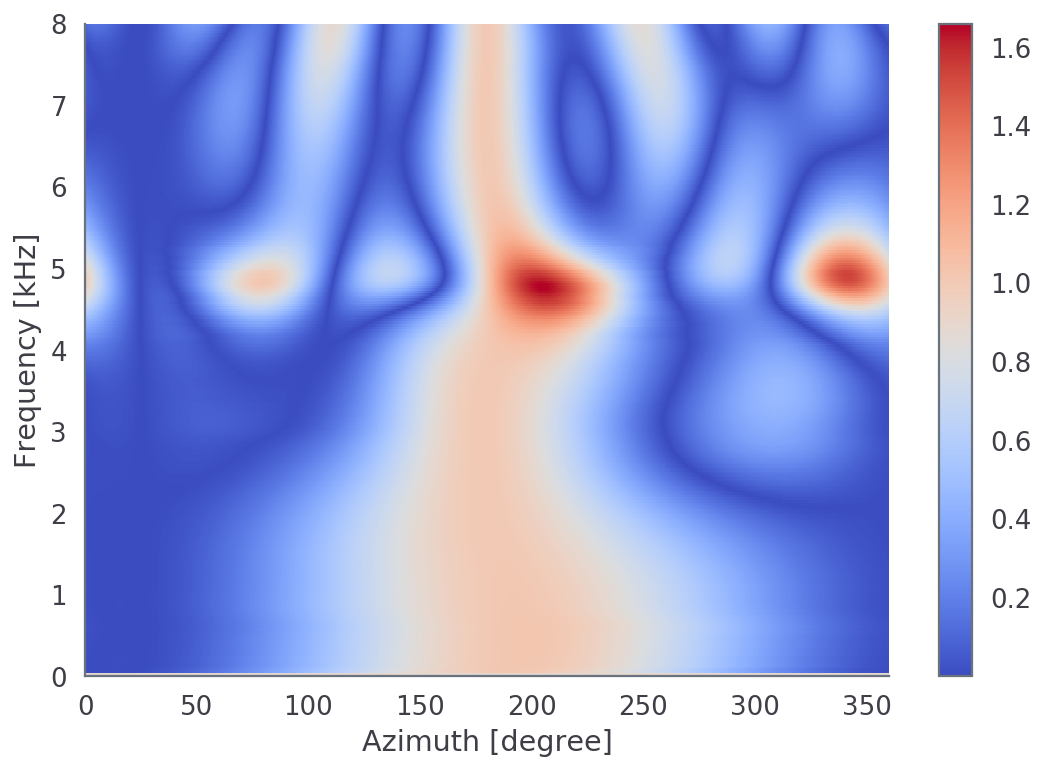

In [17]:
print(w.shape)
dl_tf_beampattern = compute_tf_beampattern(w, scanning_steering_vectors)
dl_tf_beampattern_db = to_db(dl_tf_beampattern)

if VISUALIZE_BEAMPATTERNS:
    frequency_bins = [7, 31, 63, 127]
    visualize_beampattern_1d(dl_tf_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
        signal_max_frequency, source_azimuths= azimuth_s, title="MVDR TF beam patterns")

    visualize_beampattern_1d_average(np.abs(dl_tf_beampattern[:, 0, :]), scanning_azimuth_grid, 
        frequency_range=(0, 63), source_azimuths=azimuth_s, title="MVDR TF average beam pattern")

    visualize_beampattern_2d(np.abs(dl_tf_beampattern[:, 0, :]), 
        scanning_azimuth_grid, signal_max_frequency);

(1, 256, 7, 216)


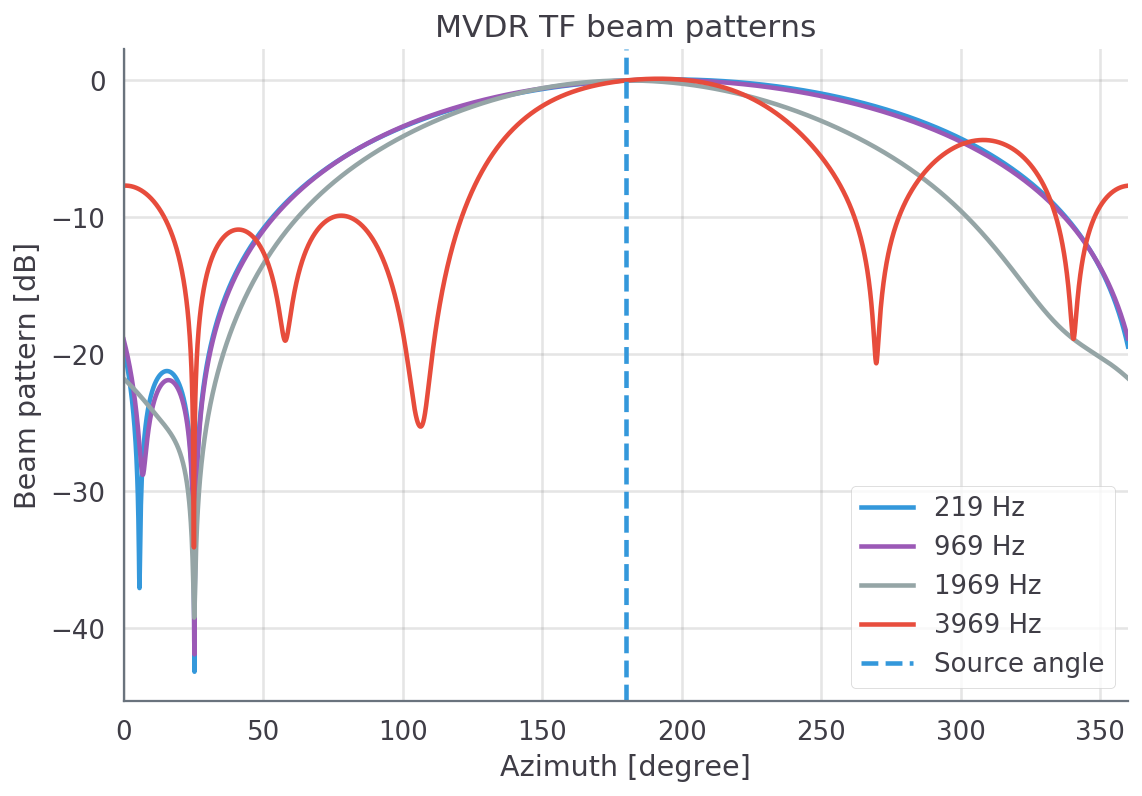

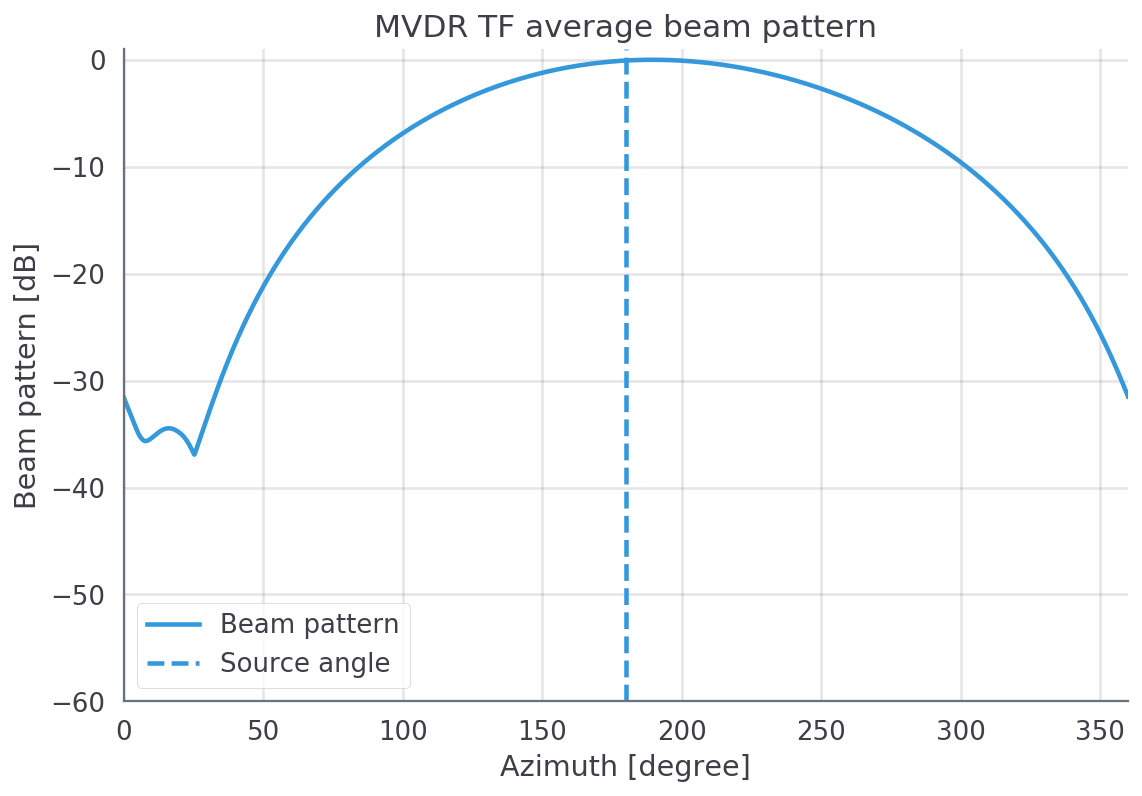

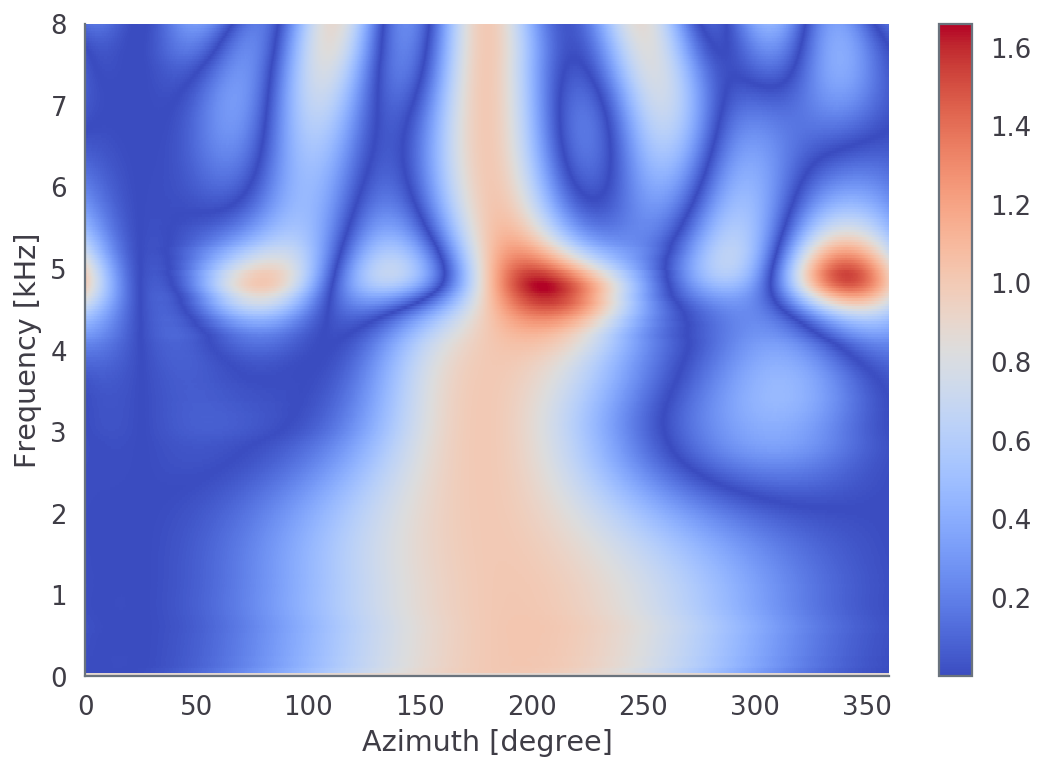

In [16]:
print(dw.shape)
dl_tf_beampattern = compute_tf_beampattern(dw[0, :, :, 15], scanning_steering_vectors)
dl_tf_beampattern_db = to_db(dl_tf_beampattern)

if VISUALIZE_BEAMPATTERNS:
    frequency_bins = [7, 31, 63, 127]
    visualize_beampattern_1d(dl_tf_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
        signal_max_frequency, source_azimuths= azimuth_s, title="MVDR TF beam patterns")

    visualize_beampattern_1d_average(np.abs(dl_tf_beampattern[:, 0, :]), scanning_azimuth_grid, 
        frequency_range=(0, 63), source_azimuths=azimuth_s, title="MVDR TF average beam pattern")

    visualize_beampattern_2d(np.abs(dl_tf_beampattern[:, 0, :]), 
        scanning_azimuth_grid, signal_max_frequency);

In [18]:
dlbeamformer.weights_.shape
w2 = dlbeamformer.weights_[0, :, :, 15]
dl_tf_beampattern = compute_tf_beampattern(dw, scanning_steering_vectors)
dl_tf_beampattern_db = to_db(dl_tf_beampattern)

if VISUALIZE_BEAMPATTERNS:
    frequency_bins = [7, 31, 63, 127]
    visualize_beampattern_1d(dl_tf_beampattern_db[:, 0, :], scanning_azimuth_grid, frequency_bins, 
        signal_max_frequency, source_azimuths= azimuth_s, title="MVDR TF beam patterns")

    visualize_beampattern_1d_average(np.abs(dl_tf_beampattern[:, 0, :]), scanning_azimuth_grid, 
        frequency_range=(0, 63), source_azimuths=azimuth_s, title="MVDR TF average beam pattern")

    visualize_beampattern_2d(np.abs(dl_tf_beampattern[:, 0, :]), 
        scanning_azimuth_grid, signal_max_frequency);

ValueError: shapes (216,7,256) and (7,) not aligned: 256 (dim 2) != 7 (dim 0)